This file allows to analyze results obtained by running experiments_competing_risk.

In [1]:
import os 
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import sys

sys.path.append('../../')
sys.path.append('../../DeepSurvivalMachines/')
from datasets import datasets

In [2]:
# Change this to analyze other datasets result
dataset = 'SUPPORT' 

In [3]:
path = '/vol/miltank/users/frou/Documents/TFM_for_medical_prognosis/Results/' # Path where the data is saved
x, t, e, cNCriates = datasets.load_dataset(dataset, path = '../', competing = False, normalize = False) # Open the data

In [4]:
from experiments.experiment import Experiment
groups = None
horizons = [0.25, 0.5, 0.75] # Horizons to evaluate the models
times_eval = np.quantile(t[e > 0], horizons)

In [5]:
from pycox.evaluation import EvalSurv
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc, integrated_brier_score
from metrics import truncated_concordance_td, auc_td, brier_score as bs

### Utils: The evaluatino metrics used
def evaluate(survival, e = e, t = t, groups = None, times_eval = []):
    folds = survival.iloc[:, -1].values
    survival = survival.iloc[:, :-1]
    survival.columns = pd.MultiIndex.from_frame(pd.DataFrame(index=survival.columns).reset_index().astype(float))
    
    times = survival.columns.get_level_values(1).unique()
    results = {}

    # If multiple risk, compute cause specific metrics
    for r in survival.columns.get_level_values(0).unique():
        for fold in np.arange(5):
            res = {}
            e_train, t_train = e[folds != fold], t[folds != fold]
            e_test,  t_test  = e[folds == fold], t[folds == fold]
            g_train, g_test = (None, None) if groups is None else (groups[folds != fold], groups[folds == fold])            

            survival_train = survival[folds != fold][r]
            survival_fold = survival[folds == fold][r]

            km = EvalSurv(survival_train.T, t_train, e_train != 0, censor_surv = 'km')
            test_eval = EvalSurv(survival_fold.T, t_test, e_test == int(r), censor_surv = km)

            res['Overall'] = {
                    "CIS": test_eval.concordance_td(), 
                }
            try:
                res['Overall']['BRS'] = test_eval.integrated_brier_score(times.to_numpy())
            except: pass

            km = (e_train, t_train)
            if len(times_eval) > 0:
                for te in times_eval:
                    try:
                        ci, km = truncated_concordance_td(e_test, t_test, 1 - survival_fold.values, times, te, km = km, competing_risk = int(r))
                        res[te] = {
                            "CIS": ci,
                            "BRS": bs(e_test, t_test, 1 - survival_fold.values, times, te, km = km, competing_risk = int(r))[0]}
                    except:
                        pass
                
                    for group in groups.unique() if groups is not None else []:
                        try:
                            km = (e_train[g_train == group], t_train[g_train == group])
                            res[te]["CIS_{}".format(group)] = truncated_concordance_td(e_test[g_test == group], t_test[g_test == group], 1 - survival_fold[g_test == group].values, times, te, km = km, competing_risk = int(r))[0]
                            res[te]["BRS_{}".format(group)] = bs(e_test[g_test == group], t_test[g_test == group], 1 - survival_fold[g_test == group].values, times, te, km = km, competing_risk = int(r))[0]

                            km = (e_train[g_train != group], t_train[g_train != group])
                            res[te]["Delta_CIS_{}".format(group)] = res[te]["CIS_{}".format(group)] - truncated_concordance_td(e_test[g_test != group], t_test[g_test != group], 1 - survival_fold[g_test != group].values, times, te, km = km, competing_risk = int(r))[0]
                            res[te]["Delta_BRS_{}".format(group)] = res[te]["BRS_{}".format(group)] - bs(e_test[g_test != group], t_test[g_test != group], 1 - survival_fold[g_test != group].values, times, te, km = km, competing_risk = int(r))[0]
                        
                        except:
                            pass
            results[(r, fold)] = pd.DataFrame.from_dict(res)
    results = pd.concat(results)
    results.index.set_names(['Risk', 'Fold', 'Metric'], inplace = True)

    return results

In [8]:
# Open file and compute performance
predictions, results, models = {}, {}, {}
for file_name in os.listdir(path):
    #if ('cox' not in file_name ) and ('finegray' not in file_name): continue
    if dataset in file_name and '.csv' in file_name: 
        model = file_name       
        model = model[model.find('_') + 1: model.index('.')]
        print("Opening :", file_name, ' - ', model)
        if 'finegray' in model in model:
            # Reinitialize index
            predictions[model] = pd.read_csv(path + file_name, header = [0], index_col = 0).T.ffill().T
            index = pd.DataFrame([[i, t] for i in ('1', '2') for t in predictions[model].columns[:100]] + [['Use', '']])
            predictions[model].columns = pd.MultiIndex.from_frame(index)
        else:
            predictions[model] = pd.read_csv(path + file_name, header = [0, 1], index_col = 0)

        results[model] = evaluate(predictions[model], groups = groups, times_eval = times_eval)

        model_file = file_name[: file_name.index('.')] + '.pickle'
        try:
            models[model] = Experiment.load(path + model_file)
        except:
            pass

# Rename
dict_name = {
        "raw_nfg": "Raw NFG",
        "raw_coxph": "Raw CoxPH",
        "raw_xgboost": "Raw XGboost",
        "raw_rsf": "Raw RSF",
        "raw_deepsurv": "Raw DeepSurv",
        "TabPFN_nfg": "TabPFN NFG",
        "TabPFN_coxph": "TabPFN CoxPH",
        "TabPFN_xgboost": "TabPFN XGboost",
        "TabPFN_rsf": "TabPFN RSF",
        "TabPFN_deepsurv": "TabPFN DeepSurv",
    }
results = pd.concat(results).rename(dict_name)
results.index.set_names('Model', level = 0, inplace = True)

Opening : SUPPORT_raw_rsf.csv  -  raw_rsf
Opening : SUPPORT_raw_deepsurv.csv  -  raw_deepsurv
Opening : SUPPORT_TabPFN_xgboost.csv  -  TabPFN_xgboost
Opening : SUPPORT_raw_xgboost.csv  -  raw_xgboost
Opening : SUPPORT_raw_coxph.csv  -  raw_coxph
Opening : SUPPORT_TabPFN_rsf.csv  -  TabPFN_rsf
Opening : SUPPORT_TabPFN_coxph.csv  -  TabPFN_coxph
Opening : SUPPORT_TabPFN_deepsurv.csv  -  TabPFN_deepsurv
Opening : SUPPORT_raw_nfg.csv  -  raw_nfg


In [9]:
# Compute average performance across fold and models
table = results.groupby(['Model', 'Risk', 'Metric']).apply(lambda x:  pd.Series(["{:.3f} ({:.3f})".format(mean, std) for mean, std in zip(x.mean(), x.std())], index = x.columns))
table = table.unstack(level=-1).stack(level=0).unstack(level=-1).loc[:, ['CIS', 'BRS']]
table = table.reorder_levels(['Risk', 'Model']).sort_index(level = 0, sort_remaining = False)

table

Metric                          CIS                                \
                            Overall           15.0           59.0   
Risk Model                                                          
1.0  Raw CoxPH        0.656 (0.007)  0.672 (0.015)  0.659 (0.007)   
     Raw DeepSurv     0.675 (0.011)  0.702 (0.020)  0.686 (0.013)   
     Raw NFG          0.663 (0.010)  0.682 (0.017)  0.669 (0.014)   
     Raw RSF          0.693 (0.006)  0.784 (0.010)  0.739 (0.007)   
     Raw XGboost      0.689 (0.008)  0.740 (0.015)  0.713 (0.007)   
     TabPFN CoxPH     0.539 (0.016)  0.564 (0.020)  0.560 (0.022)   
     TabPFN DeepSurv  0.542 (0.020)  0.556 (0.042)  0.553 (0.038)   
     TabPFN RSF       0.526 (0.013)  0.525 (0.010)  0.523 (0.009)   
     TabPFN XGboost   0.492 (0.028)  0.473 (0.053)  0.485 (0.040)   

Metric                                         BRS                 \
                              253.0        Overall           15.0   
Risk Model                                                          
1.0  Raw CoxPH        0.661 (0.009)  0.192 (0.002)  0.141 (0.005)   
     Raw DeepSurv     0.681 (0.013)  0.199 (0.008)  0.134 (0.007)   
     Raw NFG          0.669 (0.013)  0.327 (0.062)  0.152 (0.010)   
     Raw RSF          0.695 (0.008)  0.184 (0.002)  0.123 (0.005)   
     Raw XGboost      0.698 (0.007)      nan (nan)  0.368 (0.037)   
     TabPFN CoxPH     0.548 (0.017)  0.966 (0.002)  0.249 (0.014)   
     TabPFN DeepSurv  0.543 (0.032)  0.930 (0.068)  0.761 (0.046)   
     TabPFN RSF       0.508 (0.013)  0.235 (0.010)  0.236 (0.025)   
     TabPFN XGboost   0.490 (0.032)    0.394 (nan)  0.292 (0.299)   

Metric                                              
                               59.0          253.0  
Risk Model                                          
1.0  Raw CoxPH        0.207 (0.004)  0.222 (0.003)  
     Raw DeepSurv     0.195 (0.005)  0.211 (0.006)  
     Raw NFG          0.247 (0.015)  0.237 (0.010)  
     Raw RSF          0.183 (0.003)  0.206 (0.004)  
     Raw XGboost      0.379 (0.028)  0.351 (0.017)  
     TabPFN CoxPH     0.497 (0.027)  0.489 (0.010)  
     TabPFN DeepSurv  0.647 (0.021)  0.489 (0.010)  
     TabPFN RSF       0.252 (0.014)  0.261 (0.006)  
     TabPFN XGboost   0.321 (0.198)  0.305 (0.110)

# Displaying survival curves

Displays the risk scores estimated by both models

In [32]:
models_display = ['TabPFN_rsf', 'raw_rsf', 'TabPFN_coxph', 'raw_coxph']

In [29]:
np.random.seed(42)
patient_id = np.random.choice(len(predictions['TabPFN_coxph']), size = (10) )


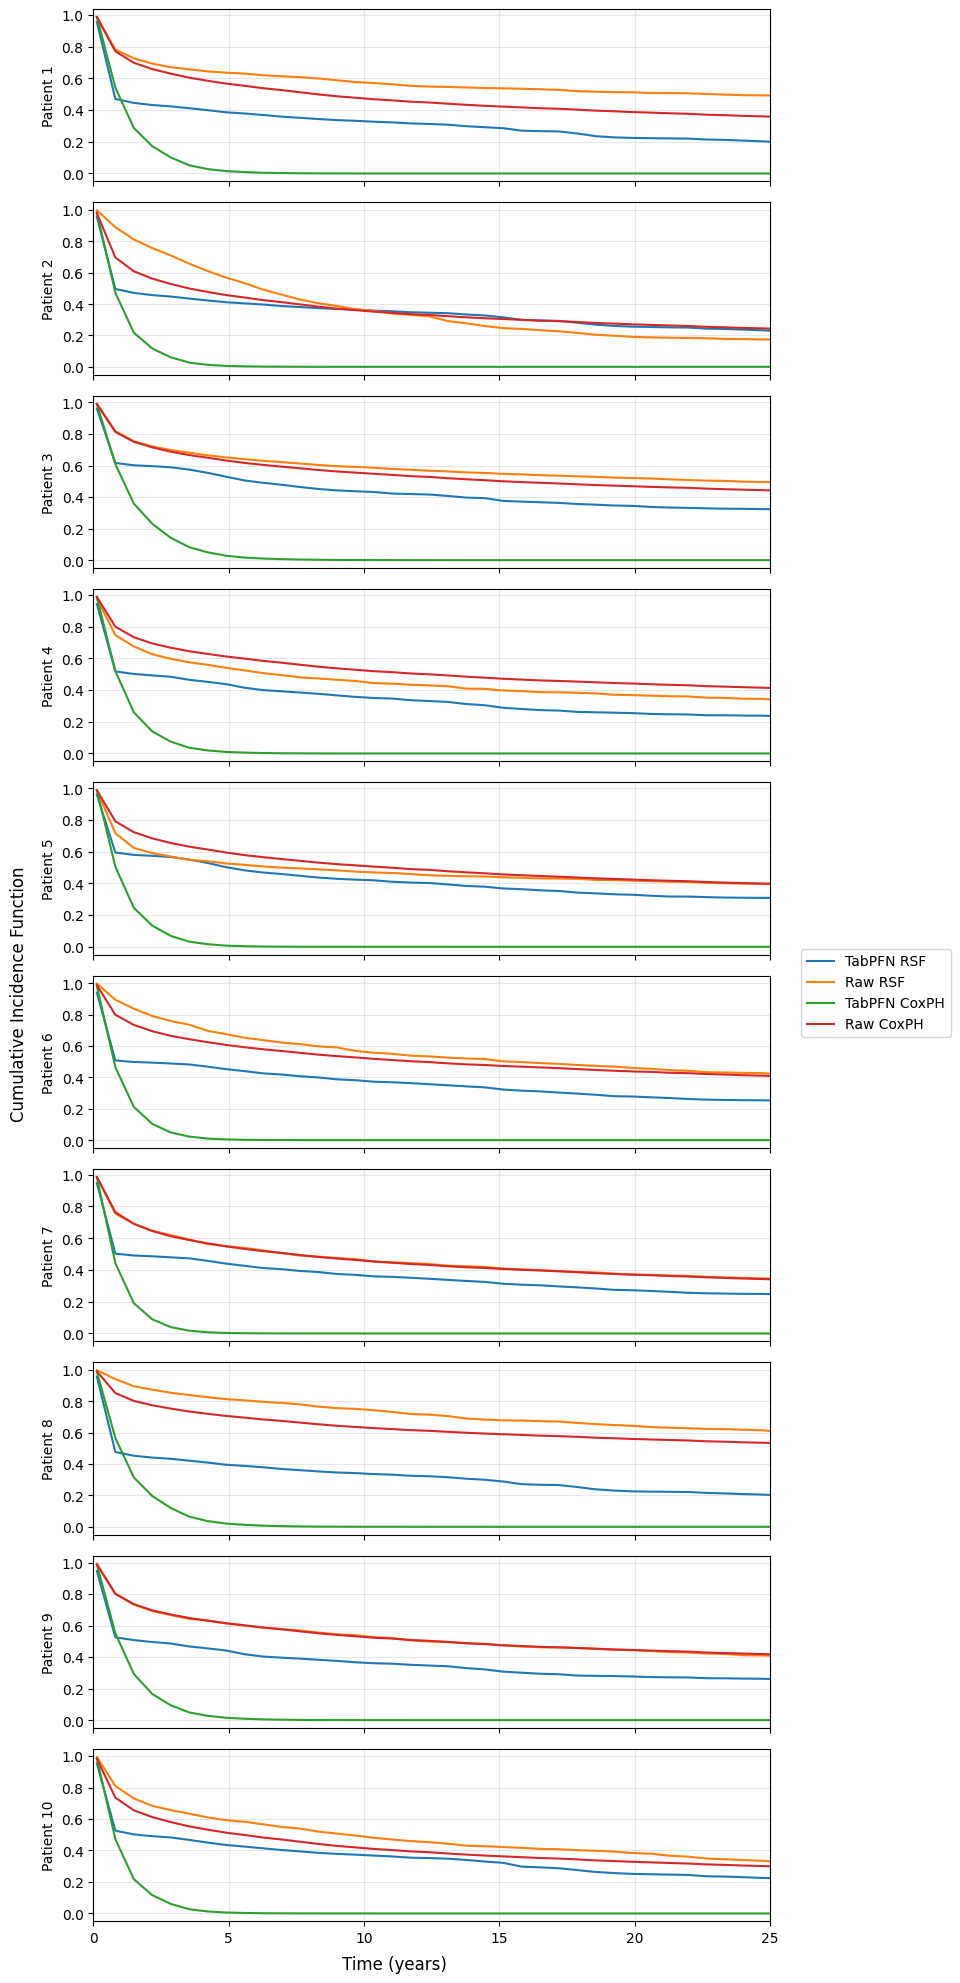

In [30]:
# single-risk plots for selected patients
risks = ['1']                         # only one risk
nrows = len(patient_id)

fig, axes = plt.subplots(nrows, 1, sharex=True, figsize=(8, 2*nrows))
axes = [axes] if nrows == 1 else list(axes)

for i, pid in enumerate(patient_id):
    ax = axes[i]
    for model in models_display:
        # predictions[model][risk] : row = patient id, cols = time grid
        s = predictions[model][risks[0]].loc[pid].rename(dict_name[model])
        s.index = s.index.astype(float)/30  # time in months
        s.plot(ax=ax, legend=False)
    ax.set_xlim(0, 25)
    ax.set_ylabel(f'Patient {i+1}')
    ax.grid(alpha=0.3)

fig.supxlabel('Time (years)')
fig.supylabel('Cumulative Incidence Function')

# one legend for all subplots
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()